# 深度学习框架中的自动微分

当对网络进行训练，对目标函数进行优化的时候，Pytorch、TensorFlow，Jax等深度学习框架可以使用**自动微分**功能求取所有变量的偏导。
在训练一个神经网络时，梯度的计算是一个关键的步骤，它为神经网络的优化提供了关键数据。
但是在面临复杂神经网络的时候导数的计算就成为一个难题，要求人们解出复杂、高维的方程是不现实的。
这就是自动微分出现的原因，当前最流行的深度学习框架如PyTorch、Tensorflow等都提供了自动微分的支持，让人们只需要很少的工作就能自动计算出复杂函数的梯度。

以下方法以一个最简单的单层神经网络为例，输入为``x``，优化参数为``w``和``b``（其中``x``、``w``和``b``都可被定义为**Tensor**），还有我们自己定义的一个损失函数``loss function``。

声明如下：

In [1]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## 张量（Tensors）与计算图（Computational graph）

``Tensor``是PyTorch实现多维数组计算和自动微分的关键数据结构。一方面，它类似于numpy的ndarray，用户可以对``Tensor``进行各种数学运算。

另一方面，当设置``.requires_grad = True``之后，在其上进行的各种操作就会被记录下来，用于后续的梯度计算，其内部实现机制被成为动态计算图(dynamic computation graph)。

下面这张图描述了上面的单层神经网络定义的**computational graph**:

![avatar](static/img/comp-graph.png)

其中, ``w``和``b``是准备优化的**parameters**。 
我们需要计算这些变量相对于损失函数的梯度。为此，我们将这些变量的特性``requires_grad``设置为True，
或者也可以通过``w.requires_grad_(True)``设置待优化变量。

`注意点`：
1. autograd机制能够记录作用于`Tensor`上的所有操作，生成一个动态计算图。图的叶子节点是输入的数据，根节点是输出的结果。当在根节点调用`.backward()`的时候就会从根到叶应用链式法则计算梯度。默认情况下，只有`.requires_grad`和`.is_leaf`两个属性都为`True`的节点才会被计算导数，并存储到grad中。
2. `requires_grad`属性默认为False，也就是`Tensor`变量默认是不需要求导的。如果一个节点的`requires_grad`是**True**，那么所有依赖它的节点`requires_grad`也会是**True**。换言之，如果一个节点依赖的所有节点都不需要求导，那么它的`requires_grad`也会是**False**。在反向传播的过程中，该节点所在的子图会被排除在外。

In [3]:
print(f"Check Gradient for w.requires_grad = {w.requires_grad} and w.is_leaf = {w.is_leaf}")
print(f"Check Gradient for b.requires_grad = {b.requires_grad} and b.is_leaf = {b.is_leaf}")
print(f"Check Gradient for z.requires_grad = {z.requires_grad} and z.is_leaf = {z.is_leaf}")

Check Gradient for w.requires_grad = True and w.is_leaf = True
Check Gradient for b.requires_grad = True and b.is_leaf = True
Check Gradient for z.requires_grad = True and z.is_leaf = False


# Function类
我们已经知道PyTorch使用动态计算图(`DAG`)记录计算的全过程，那么`DAG`是怎样建立的呢？一些同学认为`DAG`的节点是`Tensor`，这其实是不准确的。`DAG`的节点是`Function`对象，边表示数据依赖，从输出指向输入。因此`Function`类在PyTorch自动微分中位居核心地位，但是用户通常不会直接去使用，导致人们对Function类了解并不多。

每当对`Tensor`施加一个运算的时候，就会产生一个`Function`对象，它产生运算的结果，记录运算的发生，并且记录运算的输入。`Tensor`使用`.grad_fn`属性记录这个计算图的入口。反向传播过程中，autograd引擎会按照逆序，通过`Function`的`backward`依次计算梯度。




In [4]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f0a00449e50>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f0a00459970>


## 计算梯度

为了计算变量相对于`loss function`的梯度，可以简单使用`backword`函数。它会在需要被求导的节点上计算梯度值到相应的节点上。
其实就是计算：对于给定的``x``和``y``，$\frac{\partial loss}{\partial w}$ 和 $\frac{\partial loss}{\partial b}$ 的数值。
为了计算，我们通过 ``loss.backward()``，然后就可以导出``w.grad``和``b.grad``:




In [5]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2341, 0.0570, 0.2086],
        [0.2341, 0.0570, 0.2086],
        [0.2341, 0.0570, 0.2086],
        [0.2341, 0.0570, 0.2086],
        [0.2341, 0.0570, 0.2086]])
tensor([0.2341, 0.0570, 0.2086])


## 部分操作在某些点无法微分，怎么办？

在通过深度学习方法对图像特征进行操作时，不可避免有很多操作是不可微分的。而且这些操作可能在计算图的任意位置出现，这时应该如何处理呢？

- 激活函数比如ReLu()，Leaky_ReLu()这类的分段函数在某些点（如`x=0`的位置）会出现不可微的情况。

- 一些比大小的操作如argmax()，argmin()，maxpooling(),...，输入与输出不是通过加减乘除等方式联系起来的。

- 激活函数的问题，一般都会在不可微分的点赋值一个固定的梯度，如ReLu()在`x=0`处的梯度就强制为1。更多激活函数相关的内容可以参考：[Activation Functions](https://medium.com/@adea820616/activation-functions-sigmoid-relu-tahn-20e3ae726ae)

- 一些比大小的操作，可以通过`近端梯度法`将后一个计算节点的梯度跳过该操作直接赋予前一个计算节点，这样就可以使得整个计算图都可微分了。具体操作可以参考[VQGAN](https://compvis.github.io/taming-transformers/)

- 有时候计算图中会定义一个复杂的计算function，pytorch等框架不知道里面做了什么操作，怎么办呢？请看下面的微元法计算雅可比矩阵。

## 要理解梯度计算，我们要先讲一下向量-雅可比乘积（Jacobian Products）

对于一个向量函数 $\vec{y}=f(\vec{x})$，其中
$\vec{x}=\langle x_1,\dots,x_n\rangle$ 并且
$\vec{y}=\langle y_1,\dots,y_m\rangle$, $\vec{x}$ 相对于
$\vec{y}$ 的梯度可以通过 **Jacobian matrix** 计算:

$$J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)$$

所以`torch.autograd`本质上就是一个向量-雅可比乘积的计算引擎，即计算 $v^{T} \cdot J$，而所谓的梯度`grad`就是这里的`v`。

反向传播过程中一般用来传递上游传来的梯度，从而实现链式法则：

$$ J^{T} \cdot v = 
\left(\begin{array}{ccc}\frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\\vdots & \ddots & \vdots\\\frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}\end{array}\right)
\left(\begin{array}{c}\frac{\partial l}{\partial y_{1}}\\\vdots\\\frac{\partial l}{\partial y_{m}}\end{array}\right) = 
\left(\begin{array}{c}\frac{\partial l}{\partial x_{1}}\\\vdots\\\frac{\partial l}{\partial x_{n}}\end{array}\right)$$

**注意：梯度是累加的**

backward函数本身没有返回值，它计算出来的梯度存放在叶子节点的grad属性中。PyTorch文档中提到，如果grad属性不为空，新计算出来的梯度值会直接加到旧值上面。

为什么不直接覆盖旧的结果呢？这是因为有些Tensor可能有多个输出，那么就需要调用多个backward。叠加的处理方式使得backward不需要考虑之前有没有被计算过导数，只需要加上去就行了，这使得设计变得更简单。因此我们用户在反向传播之前，常常需要用zero_grad函数对导数手动清零，确保计算出来的是正确的结果。

In [6]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


## 停止梯度传播

默认情况下，所有具有``requires_grad=True``的张量都会跟踪其计算历史并支持梯度计算。 
然而，在某些情况下，我们不需要这样做。
例如，当我们训练了模型并且只想将其应用于某些输入数据时，即我们只想通过网络进行``Forward``计算。 
此时可以通过用``torch.no_grad()``块包围我们的计算代码来停止跟踪计算：

In [7]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


另一种方法也可以实现这样的功能 ``detach()``：
（如果你想实现想numpy.array中的.copy()方法，请对`tensor`使用`.clone().detach()`）

In [8]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


一些停止梯度计算的原因:
  - 一些网络中的参数需要被冻结 **frozen parameters**.
  - 加速正向推理过程 **speed up computations**.

`注意：` 当我们使用相同的值第二次调用`backward`时，获得梯度的值是不同的。
发生这种情况是因为当进行后向传播时，梯度被累积了，即将计算出的梯度值添加到计算图所有叶节点的`grad`属性。
如果你想要计算正确的梯度，需要将`grad`归零。

在后续的训练中，我们定义的优化器可以很容易地将所有待优化参数的梯度归零（optimizer.zero_grads()），不然你就需要一个一个参数归零了（w.grad.zero_()）

--------------




## 拓展阅读
- 无法自动微分的函数如何计算梯度？
- 如何局部禁用梯度的计算？
- 自动微分中的In-place操作会带来什么影响？如何解决？
- 复函数的自动微分是准确的吗？
- 想要了解以上问题，请参考[Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html)



--------------

## HomeWork

现有一张咖啡图`cof`，和一个给定模式的退化模糊核`psf`，请初始化一个`(9,9,3)`的矩阵`psf_init`并尽量优化至`psf`的情况（只能使用`img` 和 `img_deg` 的数据）。

(400, 600, 3)
torch.Size([1, 3, 400, 600])


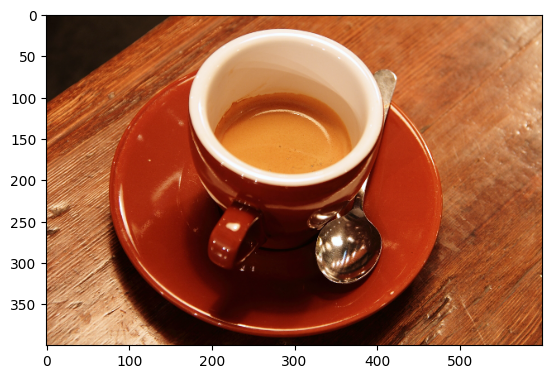

In [88]:
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
cof = data.coffee().astype(np.float64) / 255.
print(cof.shape)
plt.imshow(cof)
cof = torch.tensor(cof).unsqueeze(0).permute(0, 3, 1, 2) # [B, C, H, W]
print(cof.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(9, 9, 3)
torch.Size([1, 3, 9, 9])


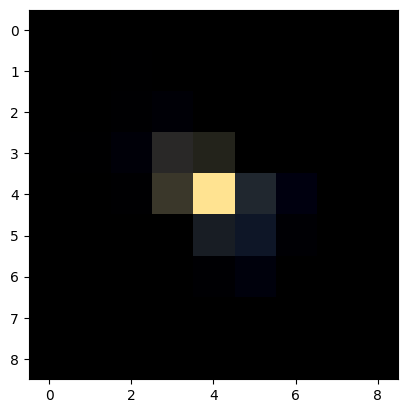

In [89]:
import scipy.io as scio
import numpy as np
psf = np.array(scio.loadmat('static/psf.mat')['psf'])
print(psf.shape)
plt.imshow(psf / psf.max())
psf = torch.tensor(psf).unsqueeze(0).permute(0, 3, 1, 2) # [B, C, H, W]
print(psf.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


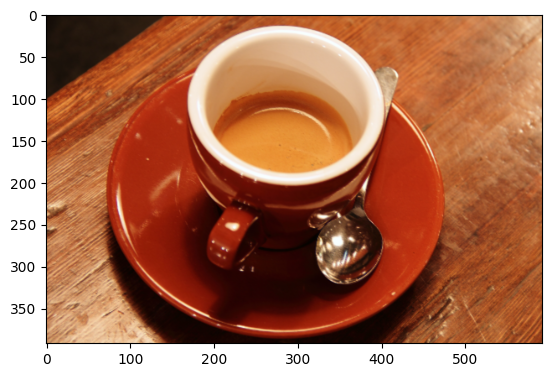

In [94]:
cof_deg = torch.concatenate((torch.nn.functional.conv2d(cof[:, 0, :, :].unsqueeze(1), psf[:, 0, :, :].unsqueeze(1), stride=1, padding=int((psf.shape[2]-1)/2)),
                             torch.nn.functional.conv2d(cof[:, 1, :, :].unsqueeze(1), psf[:, 1, :, :].unsqueeze(1), stride=1, padding=int((psf.shape[2]-1)/2)),
                             torch.nn.functional.conv2d(cof[:, 2, :, :].unsqueeze(1), psf[:, 2, :, :].unsqueeze(1), stride=1, padding=int((psf.shape[2]-1)/2))), dim=1)
plt.imshow(cof_deg.squeeze(0).permute(1, 2, 0).numpy())

In [97]:
psf_init = torch.randn_like(psf)
# write your code here to optmize the `psf_init` into `psf`
# ATTENTION: only `img`` and `img_deg` can be used
# ........................................................